In [33]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax
%matplotlib inline

from ckonlpy.tag import Twitter #konlpy twitter는 add_dictionary가 없어서, ckonlpy(customized konlpy) 사용.
twitter = Twitter()

## 입력데이터

In [34]:
df = pd.read_csv('final_data_19613.csv', sep='\t', encoding='UTF-8')
# df = df2.loc[df2['대상 선정']=='O',:]

In [35]:
df = df.fillna('N')

userdic = pd.read_csv('userdic_1906122.csv', sep='\t', encoding='UTF-8')
userdic['User Dic.'][0:1]
userdic = userdic.rename(columns = {'User Dic.':'standard'})
userdic = userdic.rename(columns = {'동의어':'missprint'})
userdic = userdic.rename(columns = {'불용단어':'stops'})
userdic_list = userdic.rename(columns = {'User Dic.':'standard'})
userdic_list = userdic.rename(columns = {'동의어':'missprint'})
userdic_list = userdic.rename(columns = {'불용단어':'stops'})
userdic_list = userdic_list.fillna('')
userdic = userdic.fillna('')
replace_word = userdic.iloc[:,1:3]
replace_word = replace_word[replace_word.missprint != '']

In [36]:
replaceword_list =  replace_word['standard'].tolist()
missword_list = replace_word['missprint'].tolist()
print(len(replaceword_list))
print(len(missword_list))

757
757


In [37]:
for i in range(len(replaceword_list)):
    df['clm_prtl_sbc'] = df['clm_prtl_sbc'].replace(missword_list[i],replaceword_list[i],regex=True)
#regex=True 설정을 주면 조사가 붙어있던 말던 단어를 다 바꿔준다.

In [38]:
df.shape

(10629, 17)

In [39]:
df[df['clm_prtl_sbc'].isnull()]

Empty DataFrame
Columns: [std_clm_type_cd, ro_y, clm_jgmt_dt, ceq_caus_cd, ceq_psit_cd, ceq_psit_nm, trim_plnt_cd, prj_vehl_cd, mdl_cd, part_sys_cd, repn_part_cd, clm_prtl_sbc, 대상 선정, 구분, 책임구, 원인, 검토결과]
Index: []

## 텍스트 전처리

In [40]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
# df['result_pred'] = df['검토결과'].astype(str).copy()
# df['target_pred'] = df['대상 선정'].astype(str).copy()
# df['charge_pred'] = df['책임구'].astype(str).copy()
# df['division_pred'] = df['구분'].astype(str).copy()

### (1) 오타, 동의어 처리(replace)

### (2) 사용자 단어 정의(User dictionary)

for word in replaceword_list: 
    twitter.add_dictionary(word, 'Noun') # for문을 통해 dictionary에 단어들을 Noun으로 추가.

# twitter.pos(df['clm_prtl_sbc'][1]) # '리어', '미장착'이 Noun으로 잘 정의되었는지 확인.

### (3) 명사 추출(Twitter)

def nouns(text):
    text = str(text)
    text = twitter.nouns(text)
    return text

df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(nouns)

### (4) 특수문자, 띄어쓰기 전처리

def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ]', ' ', text) 
    text = re.sub(' +', ' ', text)
    return text

# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['(LH)','(RH)','(사진첨부)','(우)','(좌)','[C]','A/S','C','C-10000','C-10000','F/LH','F/RH','FR','FRT',
             'Frt','frt','L/H','L/H리어','LH','LH/RH','LH쪽','R/H','R/H리어','R/LH','R/RH','RH','RH쪽','Rr','RR','rr',
             '결과','고객','고객에게','공임','광주','그랜저','그랜져','낫','낮','넥쏘','니로','당','당차량','당차량은','대리점',
             '동영상참조','레이','렌트','리무진','리어LH','리어RH','모닝','모하비','밤','벨로스터','사진','사진참조','사진첨부',
             '상기','상기차량은','새벽','새차','서비스','소하','스타렉스','스팅어','스포티지','신차','신차','심야','싼타페',
             '써비스','쏘나타','쏘렌토','쏘울','아반떼','아산','아이오닉','아침','야간','언덕','엑센트','열','울산','원인',
             '임시 넘버','임시 번호','입고','자동차','저머검내용','점검/원인','점검결과','점검내용','점검및원인','점검및조치내용',
             '점검점검','점검점검내용','조치결과','조치내용','주간','주재원','주제원','주차장','증상','지하','진입','차량',
             '차량은','철도','첨부','첨부파일','청구','출고','카 마스터','카니발','카렌스','코나','클레임','투싼',
             '팰리세이드','하이리무진','하이브리드','현     상','현    상','현   상','현  상','현 상','현산','현상','현상및점검',
             '현상및조치','화성'
]
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(preprocessing)

%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(remove_stopwords)

df['clm_prtl_sbc'].head()

Wall time: 564 ms
Wall time: 704 ms


0     엔진 룸 다량 연료 누유 발생 점검 엔진 룸 다량 연료 누유 점검 점검 내용 엔진...
1                                리어 도어 안티 치핑 필름 장착 불량 
2                      커튼 홀더 장착 불량 조치 내용 커튼 홀더 장착 후 함 
3                  및 조치 시 웨더 스트림 스트림 무 주름 발생 들뜸 교환 조치 
4                             몰딩 내부 고무 조립 불량 상태 몰딩 조립 
Name: clm_prtl_sbc, dtype: object

In [41]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7           N  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정 구분 책임구 원인  검토결과  
0   엔진 룸 다량 연료 누유 발생 점검 엔진 룸 다량 연료 누유 점검 점검 내용 엔진...     X  N   N  N  X---  
1                              리어 도어 안티 치핑 필름 장착 불량      X  N   N  N  X---  
2                    커튼 홀더 장착 불량 조치 내용 커튼 홀더 장착 후 함      X  N   N  N  X---

In [42]:
category_count = df['대상 선정'].value_counts()
category_count

X    6298
O    4331
Name: 대상 선정, dtype: int64

In [43]:
category_count = df['구분'].value_counts()
category_count

N          6298
기능(커넥터)    2244
실내부품이음     1589
하체이음        498
Name: 구분, dtype: int64

In [44]:
category_count = df['책임구'].value_counts()
category_count

N       6298
구매      3306
생산공장    1012
연구소       13
Name: 책임구, dtype: int64

In [45]:
category_count = df['원인'].value_counts()
category_count

N        6298
부품       3306
조립불량      301
결선불량      283
기타        203
체결불량      135
미결선        50
이종/간섭      30
설계/구조      13
이물         10
Name: 원인, dtype: int64

In [46]:
category_count = df['검토결과'].value_counts()
category_count

X---                    6298
O-기능(커넥터)-구매-부품         1801
O-실내부품이음-구매-부품          1165
O-하체이음-구매-부품             340
O-기능(커넥터)-생산공장-결선불량      283
O-실내부품이음-생산공장-조립불량       232
O-실내부품이음-생산공장-체결불량        91
O-기능(커넥터)-생산공장-기타         80
O-실내부품이음-생산공장-기타          78
O-하체이음-생산공장-조립불량          69
O-기능(커넥터)-생산공장-미결선        50
O-하체이음-생산공장-기타            45
O-하체이음-생산공장-체결불량          44
O-기능(커넥터)-생산공장-이종/간섭      30
O-실내부품이음-연구소-설계/구조        13
O-실내부품이음-생산공장-이물          10
Name: 검토결과, dtype: int64

In [49]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['target_pred'] = df['대상 선정'].astype(str).copy()

In [50]:
df.head(2)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7           N  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   

                                        clm_prtl_sbc 대상 선정 구분 책임구 원인  검토결과  \
0   엔진 룸 다량 연료 누유 발생 점검 엔진 룸 다량 연료 누유 점검 점검 내용 엔진...     X  N   N  N  X---   
1                              리어 도어 안티 치핑 필름 장착 불량      X  N   N  N  X---   

  est_target target_pred  
0          X           X  
1          X           X

## X, y 정의

In [51]:
x = df['clm_prtl_sbc']
y = df['대상 선정']

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)                   # X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(x) # 단어를 숫자인덱스로 변환하여 저장

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았어요.' % len(word_index))

7041개의 고유한 토큰을 찾았어요.


In [53]:
sequences[:10]

[[43,
  448,
  1322,
  82,
  565,
  4,
  2,
  43,
  448,
  1322,
  82,
  565,
  2,
  2,
  15,
  43,
  448,
  25,
  1008,
  249,
  82,
  410,
  291,
  125,
  598,
  198,
  378,
  1008,
  249,
  2137,
  45,
  91,
  330,
  67,
  936,
  125,
  1322,
  1521,
  43,
  448,
  36,
  598,
  82,
  198,
  180,
  761,
  565,
  4,
  11,
  598,
  198,
  1008,
  249,
  2137,
  45,
  91,
  330,
  67,
  82,
  198,
  566,
  125,
  87,
  1322,
  82,
  43,
  3123,
  1522,
  565,
  122,
  189,
  9,
  15,
  598,
  4045,
  2137,
  4046,
  67,
  10,
  43,
  448,
  2673,
  807,
  50,
  662,
  145,
  7,
  565,
  12,
  146,
  432,
  122,
  510,
  1008,
  291,
  87,
  1,
  291,
  180,
  50,
  654,
  4047,
  99,
  1615,
  65,
  579,
  2673,
  82,
  3124,
  96,
  4048,
  4,
  300,
  138,
  4049,
  50,
  35,
  1218,
  1523,
  570,
  122,
  189],
 [17, 13, 762, 686, 466, 75, 6],
 [177, 236, 75, 6, 9, 15, 177, 236, 75, 7, 11],
 [10, 9, 1, 92, 39, 39, 739, 680, 4, 71, 5, 9],
 [110, 36, 156, 35, 6, 49, 110, 35],
 [17,
  

168


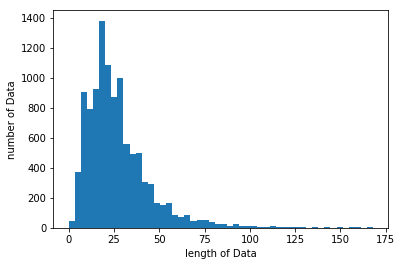

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

x = sequences
print(max(len(l) for l in x))
plt.hist([len(s) for s in x], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [55]:
tokenizer2 = Tokenizer(num_words=max_words)
tokenizer2.fit_on_texts(y)                     # y의 각 행에 토큰화를 수행
sequences2 = tokenizer2.texts_to_sequences(y)  # 단어를 숫자인덱스로 변환하여 저장

word_index2 = tokenizer2.word_index
print('%s개의 고유한 토큰을 찾았어요.' % len(word_index2))

2개의 고유한 토큰을 찾았어요.


1


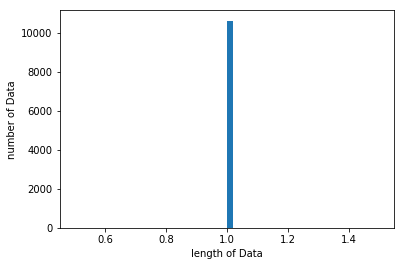

In [56]:
y = sequences2
print(max(len(l) for l in y))
plt.hist([len(s) for s in y], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [57]:
maxlen = 168
training_samples = 9566
test_samples = 10000

In [58]:
from keras.preprocessing import sequence
data_x = pad_sequences(sequences, maxlen=maxlen)
data_y = pad_sequences(sequences2)

In [59]:
data_x

array([[   0,    0,    0, ...,  570,  122,  189],
       [   0,    0,    0, ...,  466,   75,    6],
       [   0,    0,    0, ...,   75,    7,   11],
       ...,
       [   0,    0,    0, ...,  461,  210,    5],
       [   0,    0,    0, ..., 1711,  179, 7041],
       [   0,    0,    0, ...,   38,    7,   11]])

In [60]:
data_y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [2],
       [1]])

In [61]:
# labels = np.asarray(y)
print('x 데이터 텐서 크기:', data_x.shape)
print('y 데이터 텐서 크기:', data_y.shape)

x 데이터 텐서 크기: (10629, 168)
y 데이터 텐서 크기: (10629, 1)


In [21]:
indices = np.arange(data_x.shape[0])
indices2 = np.arange(data_y.shape[0])
np.random.shuffle(indices)
np.random.shuffle(indices2)
data_x = data_x[indices]
data_y = data_y[indices2]

In [22]:
x_train = data_x[:training_samples]
y_train = data_y[:training_samples]
x_test = data_x[training_samples: training_samples + test_samples]
y_test = data_y[training_samples: training_samples + test_samples]

In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9566, 168)
(9566, 2)
(1063, 168)
(1063, 2)


In [24]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[   0    0    0 ...  684    3    4]
 [   0    0    0 ... 1460   44    5]
 [   0    0    0 ...    9    7 3030]
 ...
 [   0    0    0 ...   38    3    2]
 [   0    0    0 ...  193    6    4]
 [   0    0    0 ...    3    4    5]]
[[8 9]
 [0 4]
 [0 2]
 ...
 [0 1]
 [0 2]
 [0 4]]
[[  0   0   0 ... 108  40   5]
 [  0   0   0 ...   7  16  11]
 [  0   0   0 ...   9 131   5]
 ...
 [  0   0   0 ...   1   8   2]
 [  0   0   0 ...   4 247  64]
 [  0   0   0 ...   9  15   5]]
[[0 2]
 [0 1]
 [0 2]
 ...
 [0 6]
 [0 1]
 [0 1]]


In [25]:
from keras.models import Sequential
from keras.layers import Embedding,Dense,Flatten,SimpleRNN

max_features = 10000
# maxlen = 163
# embedding_dim = 163

model = Sequential()
model.add(Embedding(max_features,32))
model.add(SimpleRNN(32))
model.add(Dense(2,activation='sigmoid'))

# model.add(Embedding(max_features,embedding_dim,input_length=maxlen))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 322,146
Trainable params: 322,146
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 7652 samples, validate on 1914 samples
Epoch 1/10
7652/7652 [==============================] - 7s 894us/step - loss: -0.8742 - acc: 0.7829 - val_loss: -1.5379 - val_acc: 0.8009
Epoch 2/10
7652/7652 [==============================] - 7s 933us/step - loss: -2.2832 - acc: 0.7931 - val_loss: -2.4393 - val_acc: 0.8009
Epoch 3/10
7652/7652 [==============================] - 6s 780us/step - loss: -3.1360 - acc: 0.7931 - val_loss: -3.0679 - val_acc: 0.8009
Epoch 4/10
7652/7652 [==============================] - 9s 1ms/step - loss: -3.8212 - acc: 0.7931 - val_loss: -3.6458 - val_acc: 0.8009
Epoch 5/10
7652/7652 [==============================] - 7s 926us/step - loss: -4.4933 - acc: 0.7931 - val_loss: -4.2305 - val_acc: 0.8009
Epoch 6/10
7652/7652 [==============================] - 6s 835us/step - loss: -5.1319 - acc: 0.7931 - val_loss: -4.5499 - val_acc: 0.8009
Epoch 7/10
7652/7652 [==============================] - 6s 847us/step - loss: 

In [27]:
import matplotlib.pyplot as plt

In [28]:
print(history.history['acc'])
print(history.history['val_acc'])
print(history.history['loss'])
print(history.history['val_loss'])

[0.7828672239746776, 0.7930606379598706, 0.7930606375548208, 0.7930606377729246, 0.7930606378975553, 0.7930606379598706, 0.7930606376171361, 0.793060638022186, 0.793060638022186, 0.7930606374613477]
[0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141, 0.8009404379995141]
[-0.8742433630603804, -2.2831627440215776, -3.136001017476275, -3.8211520371235173, -4.493268170533726, -5.131920331943989, -5.298393219351083, -5.302164802361831, -5.302307669055817, -5.302295623496136]
[-1.5379328199563977, -2.4393118391963755, -3.0679282364800433, -3.645838057359558, -4.230454182300947, -4.549887113561201, -4.642768536490956, -4.6421400591372945, -4.641090722417881, -4.642491909154654]


In [29]:
print(round(np.mean(history.history['acc'])*100,2))
print(round(np.mean(history.history['val_acc'])*100,2))

79.2
80.09


<Figure size 432x288 with 0 Axes>

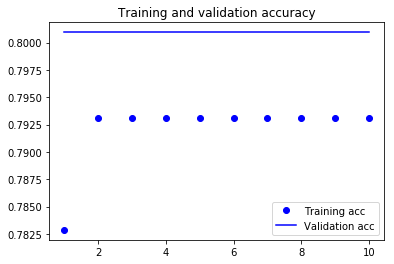

<Figure size 432x288 with 0 Axes>

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

<Figure size 432x288 with 0 Axes>

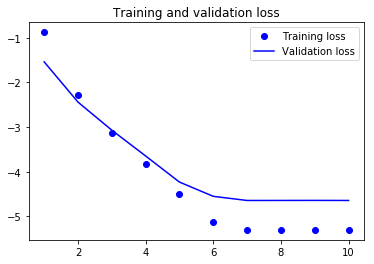

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

In [32]:
# model.load_weights('pre_trained_model.h5')
model.evaluate(x_test, y_test)

1063/1063 [==============================] - 0s 230us/step


[-5.387038796999941, 0.7906867355416658]